In [1]:
## plot within the notebook
%matplotlib inline
import warnings
import numpy as np
## No annoying warnings
warnings.filterwarnings('ignore')

In [2]:
from astrobject.utils.plot.skybins import SurveyFieldBins
ztf_fields = np.genfromtxt('data/ZTF_Fields.txt', comments='%')
bins = SurveyFieldBins(ra=ztf_fields[:,1], dec=ztf_fields[:,2])
# Fields are defined by their midpoints
# Default width and height are set to 7 degrees for now
# There is more field overlap the closer you get to the poles

In [3]:
field_idx = np.array([351, 352])
ra_range = (min(bins.ra[field_idx]) - 3.5, max(bins.ra[field_idx]) + 3.5)
dec_range = (min(bins.dec[field_idx]) - 3.5, max(bins.dec[field_idx]) + 3.5)
print ra_range
print dec_range

(-0.97059000000000006, 13.088240000000001)
(-13.28462, -6.2846200000000003)


In [4]:
import simsurvey.cadence as simul

In [8]:
simul.simulsurvey.suggest_skynoise_gain((0.01, 0.2), (18, 21), calibration=0.005)

{'gain': 0.00294660397245621, 'skynoise': nan}

In [40]:
# Make a mock survey plan (by no means realistic, just trying to capture the effect of
# moving the observed part of the sky along according to the seasons)
obs_days = np.arange(58000, 58090, 1)

bands = ['r_r_gggg', 'r_r_ggii']

obs = {'time': [], 'field': [], 'band': [], 'skynoise': []}
for k, d in enumerate(obs_days):
    for l, band in enumerate(bands[k%2]):
        if band != '_':
            for m, idx in enumerate(field_idx):
                if l <= 3 or (m == 0 and d < 58045) or (m == 1 and d >= 58045):
                    obs['time'].append(d + l / 86400.)
                    obs['field'].append(idx)
                    obs['band'].append('des%s'%band)
                    # Tuned to give 1% flux error at R=18 in combination with gain=0.25 
                    obs['skynoise'].append(400.) 
        
plan = simul.SurveyPlan(time=obs['time'], band=obs['band'], obs_field=obs['field'],
                        skynoise=obs['skynoise'],
                        fields=dict(ra=ztf_fields[:,1], dec=ztf_fields[:,2]))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x1092b9310>,
 'cbar': <matplotlib.colorbar.ColorbarBase instance at 0x10ab6dd40>,
 'collection': <matplotlib.collections.PolyCollection at 0x10ab7a350>,
 'figure': <matplotlib.figure.Figure at 0x1092acc10>}

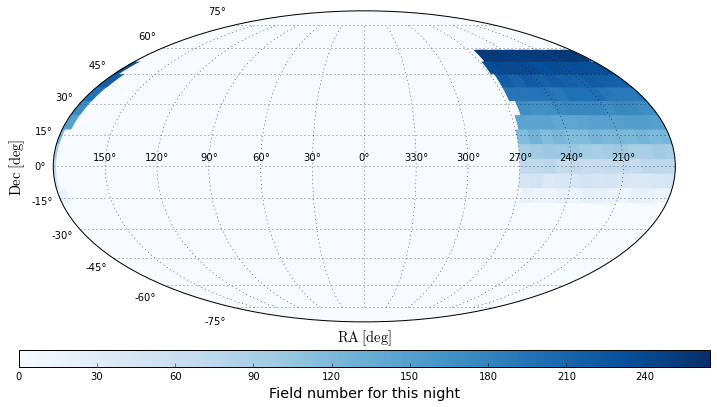

In [8]:
# Example of selected fields (last of the nights in the mock survey)
# The fields are number by the order in which they are observed.
vals = np.zeros(bins.nbins)
for k,l in enumerate(field_idx):
    vals[l] = k
    
bins.imshow(vals, cblabel="Field number for this night")

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x10b13be90>,
 'cbar': <matplotlib.colorbar.ColorbarBase instance at 0x10b154f38>,
 'collection': <matplotlib.collections.PolyCollection at 0x10b3be710>,
 'figure': <matplotlib.figure.Figure at 0x1092aca10>}

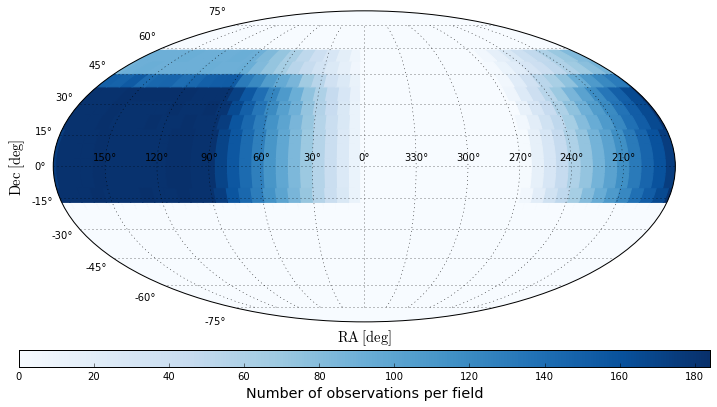

In [9]:
# Number of pointings per field
vals, _ = np.histogram(obs['field'], bins=range(bins.nbins + 1))
bins.imshow(vals, cblabel="Number of observations per field")

In [49]:
tr = simul.get_sn_generator([0.01,0.1], ratekind="custom", ratefunc=lambda z: 1e-3,
                            mjd_range=[obs_days[0] - 60, obs_days[-1] + 25],
                            ra_range=ra_range, dec_range=dec_range)
print tr.ntransient
# ra_range and dec_range defined above
# ratekind is the rate of the transient: custom with constant rate of  1e-3 
# -> comoving volumetric rate at each redshift in units of yr^-1 Mpc^-3.

317


{'ax': <matplotlib.projections.geo.MollweideAxes at 0x10cec9fd0>,
 'cbar': <matplotlib.colorbar.ColorbarBase instance at 0x10b1b6290>,
 'collection': <matplotlib.collections.PolyCollection at 0x10d914cd0>,
 'figure': <matplotlib.figure.Figure at 0x1092ac990>}

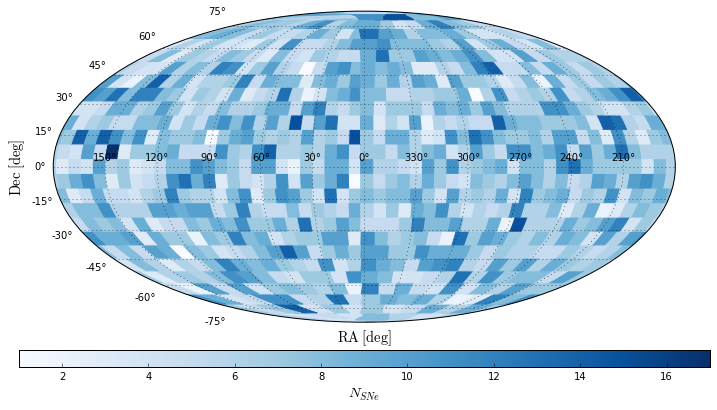

In [11]:
tr.hist_skycoverage(bins=bins)
# Since the fields can overlap, some SNe will be counted twice
# Overlapping fields partly obscure previously drawn 
# Some distortions when drawing fields near the poles (to be fixed later)

In [ ]:
# SimulSurvey class collects all required components, Transient generator, survey plan and instruments
instprop = {"desg":{"gain":0.25,"zp":30,"zpsys":'ab', 'calib_err': 0.005},
            "desr":{"gain":0.25,"zp":30,"zpsys":'ab', 'calib_err': 0.005},
            "desi":{"gain":0.25,"zp":30,"zpsys":'ab', 'calib_err': 0.005}}

SNe observed: 314 out of 317


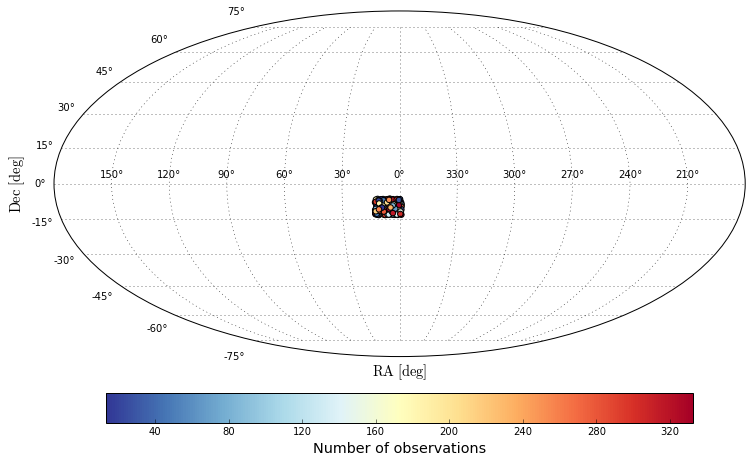

In [50]:
survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop)

# Generate the lightcurves. This first determines the dates on which each transient was observed
# to keep the number of lightcurve points that are calculated to a minimum
lcs = survey.get_lightcurves()
n_obs = np.array([len(a) for a in survey.plan.observed])
survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of observations", mask=(n_obs > 0))
print 'SNe observed: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

In [51]:
lcs[10:20]

[<Table length=336>
      time     band      flux        fluxerr      zp  zpsys
    float64    str4    float64       float64    int64  str2
 ------------- ---- ------------- ------------- ----- -----
       58000.0 desr 1418.60387985 407.777748461    30    ab
 58000.0000231 desr 1757.65529595 407.777894335    30    ab
 58000.0000463 desg 1224.34515659 406.065078325    30    ab
 58000.0000579 desg 791.996759758 406.065134458    30    ab
 58000.0000694 desg 1770.82032287 406.065190592    30    ab
  58000.000081 desg 1182.79902526 406.065246727    30    ab
       58001.0 desr 2925.05449302 415.567487623    30    ab
 58001.0000231 desr 3315.06433398 415.567704647    30    ab
 58001.0000463 desg 3030.94619926 412.324866841    30    ab
 58001.0000579 desg 2605.65016399 412.324958014    30    ab
           ...  ...           ...           ...   ...   ...
       58073.0 desr 14646.6756414 466.674797005    30    ab
 58073.0000231 desr 14950.2817415 466.674797005    30    ab
       58074.0 desr 

In [52]:
# example lightcurve
lcs[0]

time,band,flux,fluxerr,zp,zpsys
float64,str4,float64,float64,int64,str2
58000.0,desr,10431.480935,450.911682351,30,ab
58000.0000231,desr,10721.3559569,450.911849382,30,ab
58001.0,desr,13011.6432008,458.300744019,30,ab
58001.0000231,desr,13088.4936676,458.300919542,30,ab
58002.0,desr,13886.2230963,465.737757986,30,ab
58002.0000231,desr,13165.3374232,465.737923245,30,ab
58003.0,desr,15868.3112412,472.468828703,30,ab
58003.0000231,desr,16121.7845315,472.46897343,30,ab
58004.0,desr,17206.5006788,478.238316933,30,ab


In [53]:
# Its parameters
lcs[0].meta

{'c': -0.012488766946365684,
 'mwebv': 0.031018557026982307,
 't0': 58009.66678266383,
 'x0': 0.00075523858541836275,
 'x1': -0.72197778935947787,
 'z': 0.06296196989918089}

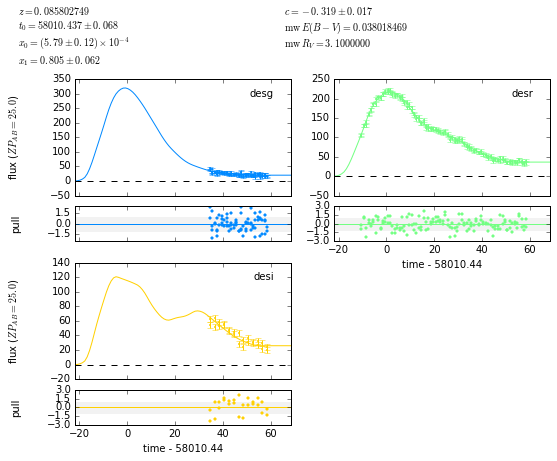

In [54]:
# Example lightcurve fit
lc = lcs[0]

import sncosmo
survey.generator.model.set(z=lc.meta['z'],mwebv=lc.meta['mwebv'])
res, fitted_model = sncosmo.fit_lc(lc, survey.generator.model, ['t0', 'x0', 'x1', 'c'])

_ = sncosmo.plot_lc(lc, model=fitted_model, errors=res.errors)

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x119900e10>,
 'cbar': <matplotlib.colorbar.Colorbar instance at 0x119905ab8>,
 'figure': <matplotlib.figure.Figure at 0x119900190>,
 'plot': <matplotlib.collections.PathCollection at 0x119544950>}

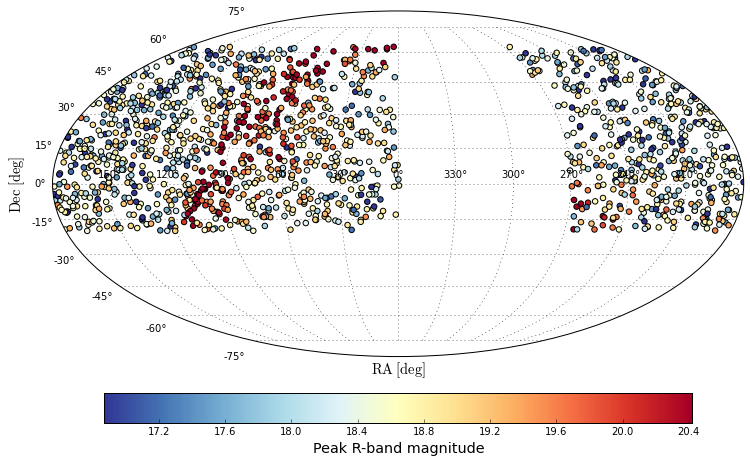

In [28]:
# MW E(B-V) is now automatically included in the lc model,
# so MW can be seen in magnitudes
peak_mag = survey.generator.get_bandmag(band='bessellr', magsys='vega', t=0) # t is time relative to t0
survey.generator.show_skycoverage(cscale=peak_mag, cblabel="Peak R-band magnitude", mask=(n_obs > 0))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x119ad5750>,
 'cbar': <matplotlib.colorbar.Colorbar instance at 0x119469a28>,
 'figure': <matplotlib.figure.Figure at 0x119f6fd50>,
 'plot': <matplotlib.collections.PathCollection at 0x119458c50>}

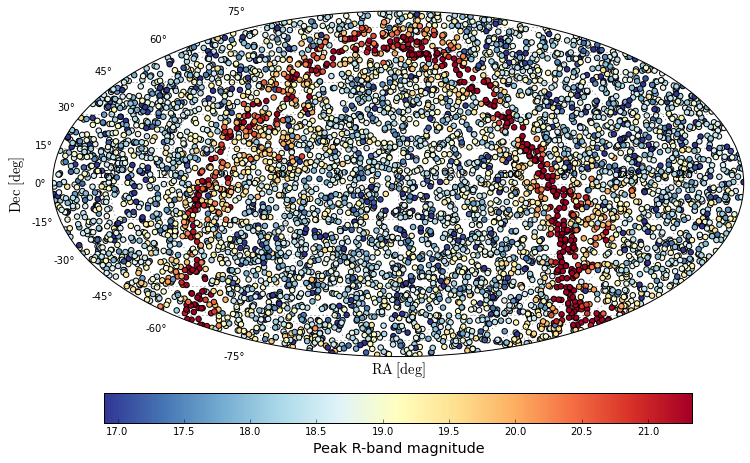

In [29]:
# It's more obvious when using the whole sample
survey.generator.show_skycoverage(cscale=peak_mag, cblabel="Peak R-band magnitude")